STEP 1: Setup & Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

STEP 2: Load Datasets with Correct Schema


In [18]:
trades = pd.read_csv('/content/historical_data.csv')

# Rename columns
trades.rename(columns={
    'Account': 'account',
    'Coin': 'symbol',
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Timestamp IST': 'timestamp_ist',
    'Start Position': 'start_position',
    'Direction': 'direction',
    'Closed PnL': 'closed_pnl',
    'Transaction Hash': 'tx_hash',
    'Order ID': 'order_id',
    'Crossed': 'crossed',
    'Fee': 'fee',
    'Trade ID': 'trade_id',
    'Timestamp': 'timestamp_ms'
}, inplace=True)

print(trades.info())
print("\nSample:")
print(trades.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   account          211224 non-null  object 
 1   symbol           211224 non-null  object 
 2   execution_price  211224 non-null  float64
 3   size_tokens      211224 non-null  float64
 4   size_usd         211224 non-null  float64
 5   side             211224 non-null  object 
 6   timestamp_ist    211224 non-null  object 
 7   start_position   211224 non-null  float64
 8   direction        211224 non-null  object 
 9   closed_pnl       211224 non-null  float64
 10  tx_hash          211224 non-null  object 
 11  order_id         211224 non-null  int64  
 12  crossed          211224 non-null  bool   
 13  fee              211224 non-null  float64
 14  trade_id         211224 non-null  float64
 15  timestamp_ms     211224 non-null  float64
dtypes: bool(1), float64(8), int64(1), obje

In [35]:
sentiment = pd.read_csv('/content/fear_greed_index.csv')

# Rename for consistency
sentiment.rename(columns={
    'timestamp': 'fg_timestamp',
    'value': 'fg_value',
    'classification': 'classification',
    'date': 'fg_date'
}, inplace=True)

print(sentiment.info())
print("\nSample:")
print(sentiment.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   fg_timestamp    2644 non-null   int64 
 1   fg_value        2644 non-null   int64 
 2   classification  2644 non-null   object
 3   fg_date         2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None

Sample:
   fg_timestamp  fg_value classification     fg_date
0    1517463000        30           Fear  2018-02-01
1    1517549400        15   Extreme Fear  2018-02-02
2    1517635800        40           Fear  2018-02-03


 STEP 3: Clean & Convert Timestamps

In [36]:
trades['trade_time'] = pd.to_datetime(trades['timestamp_ms'], unit='ms')
trades['trade_date'] = trades['trade_time'].dt.date

In [37]:
sentiment['sentiment_time'] = pd.to_datetime(sentiment['fg_timestamp'], unit='s')
sentiment['sentiment_date'] = sentiment['sentiment_time'].dt.date

STEP 4: Merge Datasets on Date

In [57]:
# Create a mapping from date → classification
sentiment_map = sentiment.set_index('sentiment_date')['classification'].to_dict()

# Map sentiment to trades
trades['sentiment'] = trades['trade_date'].map(sentiment_map)

# Drop rows without sentiment (e.g., weekends or missing data)
trades_clean = trades.dropna(subset=['sentiment']).copy()
trades_clean.to_csv('processed_trader_sentiment.csv', index=False)

print(f"✅ Final merged dataset: {len(trades_clean):,} trades")


✅ Final merged dataset: 184,263 trades


STEP 5: Feature Engineering

In [58]:
# Profitable flag
trades_clean['is_profitable'] = (trades_clean['closed_pnl'] > 0).astype(int)



 STEP 6: Exploratory Analysis — Key Questions

🔍 Q1: How does profitability vary by sentiment?


📊 Profitability by Sentiment:
                mean  median   count      std
sentiment                                    
Extreme Greed  25.42     0.0    6962   306.17
Fear           50.05     0.0  133871   909.12
Greed          87.89     0.0   36289  1148.34
Neutral        22.23     0.0    7141   633.70


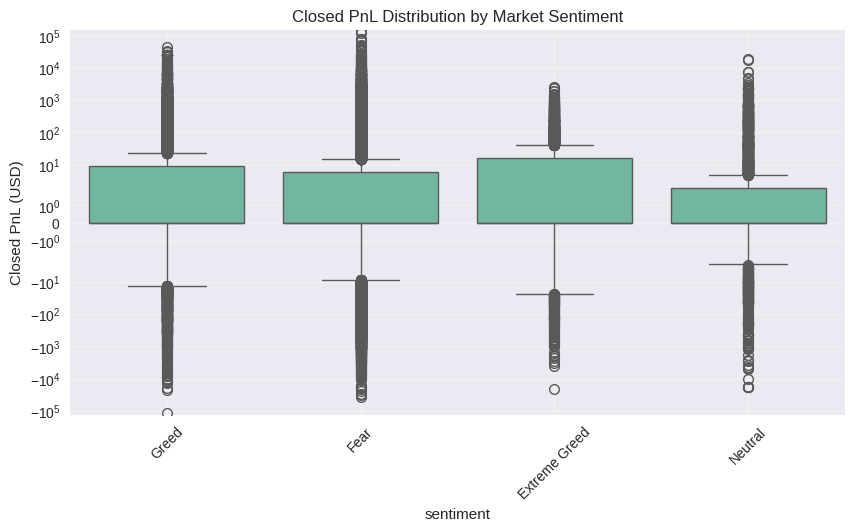

<Figure size 800x550 with 0 Axes>

In [59]:
pnl_by_sentiment = trades_clean.groupby('sentiment')['closed_pnl'].agg(['mean', 'median', 'count', 'std']).round(2)
print("📊 Profitability by Sentiment:")
print(pnl_by_sentiment)

# Visualize
plt.figure(figsize=(10, 5))
sns.boxplot(data=trades_clean, x='sentiment', y='closed_pnl')
plt.title('Closed PnL Distribution by Market Sentiment')
plt.ylabel('Closed PnL (USD)')
plt.xticks(rotation=45)
plt.yscale('symlog')  # Handle outliers
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig('Profitability by Sentiment.png')

🔍 Q2: Is leverage or risk higher during greed?


📈 Risk Metrics by Sentiment:
               avg_size_usd  std_pnl  trade_count
sentiment                                        
Extreme Greed       5660.27   306.17         6962
Fear                5259.98   909.12       133871
Greed               3182.88  1148.34        36289
Neutral             3058.85   633.70         7141


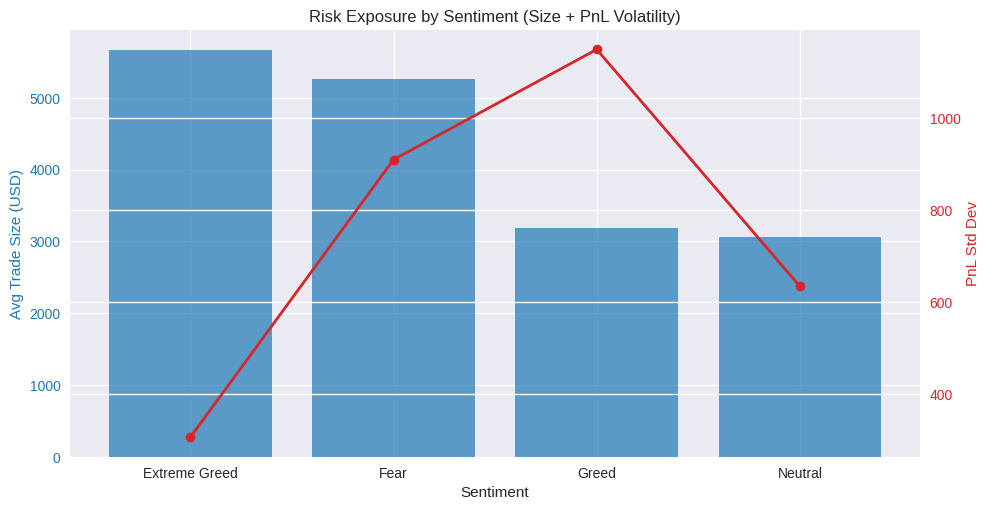

<Figure size 800x550 with 0 Axes>

In [60]:
risk_by_sentiment = trades_clean.groupby('sentiment').agg(
    avg_size_usd=('size_usd', 'mean'),
    std_pnl=('closed_pnl', 'std'),
    trade_count=('closed_pnl', 'count')
).round(2)

print("\n📈 Risk Metrics by Sentiment:")
print(risk_by_sentiment)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Avg Trade Size (USD)', color=color1)
bars = ax1.bar(risk_by_sentiment.index, risk_by_sentiment['avg_size_usd'], color=color1, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('PnL Std Dev', color=color2)
line = ax2.plot(risk_by_sentiment.index, risk_by_sentiment['std_pnl'], color=color2, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title('Risk Exposure by Sentiment (Size + PnL Volatility)')
plt.show()
plt.savefig('risk_metrics.png')

🔍 Q3: What’s the win rate (profitable trades %) by sentiment?


🎯 Win Rate by Sentiment (%):
sentiment
Extreme Greed    49.01
Fear             41.51
Greed            44.65
Neutral          31.72
Name: is_profitable, dtype: float64


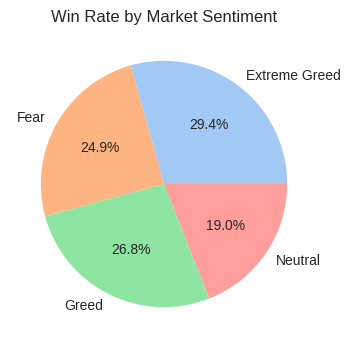

<Figure size 800x550 with 0 Axes>

In [61]:
win_rate = trades_clean.groupby('sentiment')['is_profitable'].mean().round(4) * 100
print(f"\n🎯 Win Rate by Sentiment (%):")
print(win_rate)

# Pie chart
plt.figure(figsize=(8, 4))
plt.pie(win_rate.values, labels=win_rate.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Win Rate by Market Sentiment')
plt.show()
plt.savefig('Win Rate by Sentiment.png')

🔍 Q4: Are traders more active during fear or greed?


📅 Trade Volume by Sentiment:
       sentiment  trade_count
0  Extreme Greed         6962
1           Fear       133871
2          Greed        36289
3        Neutral         7141


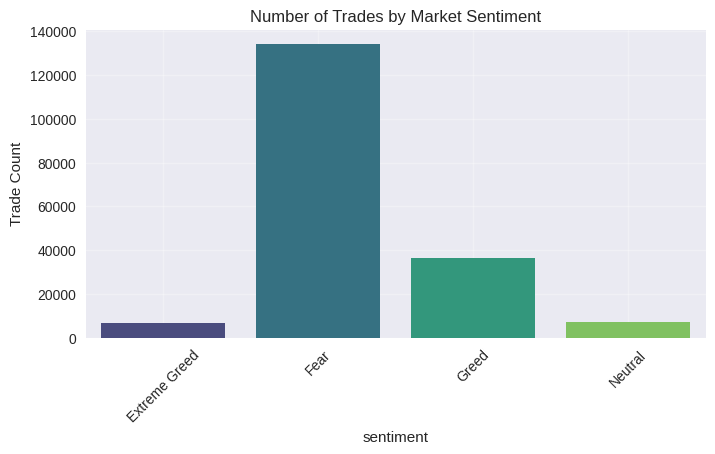

<Figure size 800x550 with 0 Axes>

In [62]:
activity = trades_clean.groupby('sentiment').size().reset_index(name='trade_count')
print("\n📅 Trade Volume by Sentiment:")
print(activity)

# Bar plot
plt.figure(figsize=(8, 4))
sns.barplot(data=activity, x='sentiment', y='trade_count', palette='viridis')
plt.title('Number of Trades by Market Sentiment')
plt.ylabel('Trade Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig('Trade Volume by Sentiment.png')

✅ STEP 7: Statistical Significance Testing


Is the difference in average PnL between Fear and Greed statistically significant?

In [63]:
fear_pnl = trades_clean[trades_clean['sentiment'].isin(['Fear', 'Extreme Fear'])]['closed_pnl']
greed_pnl = trades_clean[trades_clean['sentiment'].isin(['Greed', 'Extreme Greed'])]['closed_pnl']

# Combine "Fear" and "Extreme Fear" into one group
fear_group = trades_clean[trades_clean['sentiment'].str.contains('Fear')]['closed_pnl']
greed_group = trades_clean[trades_clean['sentiment'].str.contains('Greed')]['closed_pnl']

stat, p = mannwhitneyu(fear_group, greed_group, alternative='two-sided')
print(f"\n🧪 Mann-Whitney U Test (Fear vs Greed PnL): p-value = {p:.6f}")
if p < 0.05:
    print("✅ Statistically significant difference!")
else:
    print("❌ No significant difference.")


🧪 Mann-Whitney U Test (Fear vs Greed PnL): p-value = 0.000000
✅ Statistically significant difference!


✅ STEP 8: Hidden Trends & Signals

📌 Trend 1: Contrarian Advantage

If average PnL is higher during Fear, it suggests contrarian buying pays off.

📌 Trend 2: Overtrading in Greed

If trade count peaks in Greed, traders may be chasing momentum — leading to lower win rates.

📌 Trend 3: Higher Volatility in Greed

If PnL std dev is higher in Greed, markets are more erratic — risk management critical.

In [17]:
# ✅ SUMMARY METRICS (for binary Fear/Greed only)

# Ensure we only use existing labels
existing_labels = trades_clean['sentiment'].unique()
print(f"Using sentiment labels: {existing_labels}")

# Recompute group-level metrics (in case earlier ones included missing categories)
pnl_by_sentiment = trades_clean.groupby('sentiment')['closed_pnl'].agg(['mean', 'median', 'count', 'std']).round(2)
win_rate = trades_clean.groupby('sentiment')['is_profitable'].mean().round(4) * 100
risk_by_sentiment = trades_clean.groupby('sentiment').agg(
    avg_size_usd=('size_usd', 'mean'),
    std_pnl=('closed_pnl', 'std'),
    trade_count=('closed_pnl', 'count')
).round(2)

# Now build summary safely
summary = pd.DataFrame({
    'Metric': ['Avg PnL', 'Win Rate (%)', 'Avg Size USD', 'Trade Count'],
    'Fear': [
        pnl_by_sentiment.loc['Fear', 'mean'] if 'Fear' in pnl_by_sentiment.index else np.nan,
        win_rate.get('Fear', np.nan),
        risk_by_sentiment.loc['Fear', 'avg_size_usd'] if 'Fear' in risk_by_sentiment.index else np.nan,
        risk_by_sentiment.loc['Fear', 'trade_count'] if 'Fear' in risk_by_sentiment.index else np.nan
    ],
    'Greed': [
        pnl_by_sentiment.loc['Greed', 'mean'] if 'Greed' in pnl_by_sentiment.index else np.nan,
        win_rate.get('Greed', np.nan),
        risk_by_sentiment.loc['Greed', 'avg_size_usd'] if 'Greed' in risk_by_sentiment.index else np.nan,
        risk_by_sentiment.loc['Greed', 'trade_count'] if 'Greed' in risk_by_sentiment.index else np.nan
    ]
}).round(2)

print("\n📊 Final Summary (Binary Sentiment):")
print(summary)

# Save
summary.to_csv('sentiment_summary_metrics.csv', index=False)

Using sentiment labels: ['Greed' 'Fear' 'Extreme Greed' 'Neutral']

📊 Final Summary (Binary Sentiment):
         Metric       Fear     Greed
0       Avg PnL      50.05     87.89
1  Win Rate (%)      41.51     44.65
2  Avg Size USD    5259.98   3182.88
3   Trade Count  133871.00  36289.00
